<a href="https://colab.research.google.com/github/beatrizpinheiro/Deep-Residual-Learning-for-Image-Recognition/blob/main/Deep_Residual_Learning_for_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementar os experimentos (comparando n={3, 5}) descritos na sessão 4.2 do artigo "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" seguindo a API descrita em sala.

## API

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from collections import defaultdict
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Get cpu, gpu or mps device for training.
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

Using cpu device


### Dataset

In [ ]:
class Dataset:
  def __init__(self, batch_size, do_per_pixel_mean_sub=True, do_data_augmentation=True):

    self.batch_size = batch_size
    self.do_per_pixel_mean_sub = do_per_pixel_mean_sub
    self.do_data_augmentation = do_data_augmentation
    self.dataloaders = {}
    self.per_pixel_mean = None

    transform = transforms.Compose([transforms.PILToTensor()])
    cifar100_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
    cifar100_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_dataset, val_dataset, test_dataset = self.get_dataloaders(cifar100_train, cifar100_test)

    self.dataloaders['train'] = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
    self.dataloaders['val'] = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
    self.dataloaders['test'] = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)


  def get_dataloaders(self, cifar100_train, cifar100_test):
    cifar100_test.data.transpose((0, 3, 1, 2))

    X_train, X_val, y_train, y_val = self.separate_train_val(cifar100_train)
    X_test, y_test = cifar100_test.data.transpose((0, 3, 1, 2)).astype("float32"), cifar100_test.targets
    X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

    if self.do_data_augmentation:
        X_train = self.data_augumentation(X_train)

    if self.do_per_pixel_mean_sub:
        X_train, X_val, X_test = self.per_pixel_mean_sub(X_train, X_val, X_test)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    return train_dataset, val_dataset, test_dataset


  def separate_train_val(self, cifar100_train, val_size=5000):
    X_train = cifar100_train.data.transpose((0, 3, 1, 2)).astype("float32")
    y_train = cifar100_train.targets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train, random_state=42)

    X_train, X_val, y_train, y_val = torch.tensor(X_train), torch.tensor(X_val), torch.tensor(y_train), torch.tensor(y_val)

    return X_train, X_val, y_train, y_val


  def data_augumentation(self, X_train):
    hflip = transforms.RandomHorizontalFlip(p=0.5)
    crop = transforms.RandomCrop(32, 4)
    X_train = hflip(X_train)
    X_train = crop(X_train)
    return X_train


  def per_pixel_mean_sub(self, X_train, X_val, X_test):
    per_pixel_mean = torch.mean(X_train, dim=0)
    ppmean_sub = transforms.Lambda(lambda img: img - per_pixel_mean)
    X_train = ppmean_sub(X_train)
    X_val = ppmean_sub(X_val)
    X_test = ppmean_sub(X_test)
    return X_train, X_val, X_test

#### Download dataset

In [ ]:
batch_size = 128
dataset = Dataset(batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:01<00:00, 105022802.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Estrutura

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self, n, show_net_size, use_residual, save_conv_outputs = False):
      super().__init__()
      self.n = n
      self.use_residual = use_residual
      self.show_net_size = show_net_size
      self.identity = nn.Identity()
      self.ReLU = nn.ReLU()
      # layer conv output
      self.save_conv_outputs = save_conv_outputs
      self.conv_outputs_std = torch.zeros(6*n+1)

      # features: [in_channels, out_channels, kernel, stride, padding]
      self.first_layer_features = [3,16,3,1,1]
      self.features = [[16,16,3,1,1], [32,32,3,1,1], [64,64,3,1,1]]

      self.conv_layers = torch.nn.ModuleList()
      self.first_layer = self.construct_layer(*self.first_layer_features)
      self.conv_layers.append(self.first_layer)

      for idx_feature, feature in enumerate(self.features):
        for idx_n in range(2*self.n):
          in_channels, out_channels, kernel, stride, padding = feature
          # se tiver iterando sobre a ultima camada convolucional de cada nível, o output_channels deve ser do mesmo tamanho que o input da próxima camada
          if idx_n == (2*self.n) -1 and idx_feature < len(self.features) - 1:
            out_channels *= 2
            stride = 2

          layer = self.construct_layer(in_channels, out_channels, kernel, stride, padding)
          self.conv_layers.append(layer)

      self.global_avg_pooling_layer = nn.AvgPool2d(kernel_size = 8)

      dummy_input = torch.randn(1, 3, 32, 32)
      conv_output = self.forward_conv(dummy_input)
      batch_size, num_channels, out_height, out_width = conv_output.size()
      self.num_features = num_channels * out_height * out_width
      self.linear_layers = nn.ModuleList([
            nn.Linear(num_channels, 10)
        ])



  def construct_layer(self, in_channels, out_channels, kernel, stride, padding):
    layer = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
      nn.BatchNorm2d(out_channels),
     )

    nn.init.kaiming_normal_(layer[0].weight)
    nn.init.constant_(layer[0].bias, 0)
    return layer


  def forward(self, x, get_only_conv=False):
    batch_size = x.size(0)
    conv_output = self.forward_conv(x)
    pool_output = self.global_avg_pooling_layer(conv_output)
    flatten = pool_output.view(batch_size, -1)
    linear_output = self.forward_linear(flatten)
    return linear_output


  def shortcut_connection(self, residual, conv_output):
    residual = self.identity(residual)
    dim_output_residual = residual.size()[1]
    dim_input_conv = conv_output.size()[1]

    # caso a conexão seja entre uma layer com número de filtros diferentes vamos aplicar a segunda opção do artigo:
    # utilizar uma 1x1 conv e com stride = 2 para ficar com o mesmo size e então realizar a soma
    if dim_output_residual != dim_input_conv:
        stride = 1 if residual.size()[3] == conv_output.size()[3] else 2 # stride não muda para a primeira camada
        conv_1x1_params = nn.Conv2d(dim_output_residual, dim_input_conv, kernel_size=1, stride=stride, bias=False)
        batchnorm_params = nn.BatchNorm2d(dim_input_conv)

        conv_1x1_params = conv_1x1_params.to(residual.device)
        batchnorm_params = batchnorm_params.to(residual.device)

        residual = conv_1x1_params(residual) # a residual passa a ter a mesma dimensão da camada, possibilitando fazer a "linha pontilhada" do artigo
        residual = batchnorm_params(residual)
    return residual


  def forward_conv(self, x):
      residual = x
      conv_output = x
      conv_outputs_sizes = []
      total_shortcuts = 0
      for idx_layer, conv_layer in enumerate(self.conv_layers):
        if self.show_net_size:
            conv_outputs_sizes.append(conv_output.size())

        conv_output = conv_layer(conv_output)

        # Analysis of Layer Responses
        if self.save_conv_outputs:
          std = self.get_std_layer_responses(conv_output)
          self.conv_outputs_std[idx_layer] += std

        if self.use_residual:
            apply_shortcut = idx_layer % 2 != 0 # as conexões residuais são aplicadas em camadas não camadas sim

        # aplicar a conexão residual
        if self.use_residual and apply_shortcut:
            total_shortcuts += 1
            residual = self.shortcut_connection(residual, conv_output)
            conv_output = torch.add(conv_output, residual)
            conv_output = self.ReLU(conv_output)
            residual = conv_output
        else:
            conv_output = self.ReLU(conv_output)

      if self.show_net_size:
        print(f"==== REDES CONVOLUCIONAIS PARA: n = {self.n} ====")
        for conv_size in conv_outputs_sizes:
            print(conv_size)
        print(f"\n\nn = {self.n}")
        print('-'*10)
        print(f"TOTAL DE CAMADAS CONVOLUCIONAIS: {len(self.conv_layers)}")
        print(f"TOTAL DE CAMADAS COM PESOS (CONV + LINEAR): {len(self.conv_layers)+1}")
        print(f"TOTAL DE CAMADAS ESPERADAS PELO ARTIGO: 6n + 2 = {6*self.n + 2}")
        print('-'*10)
        self.show_net_size = False
        print(f"TOTAL DE SHORTCUT CONNECTIONS: {total_shortcuts}")
        print(f"TOTAL DE CAMADAS SHORTCUT CONNECTIONS ESPERADOS [caso use_residual=True]: 3n = {3*self.n}")

      return conv_output


  def forward_linear(self, x):
    linear_output = x
    for linear_layer in self.linear_layers:
      linear_output = linear_layer(linear_output)
    return linear_output

  def get_std_layer_responses(self, conv_output):
    averages = torch.mean(conv_output, dim=(2, 3))
    std_dev = torch.std(averages)
    return std_dev.item()

### Learner

In [ ]:
class Learner:
    def __init__(self, n=1, learning_rate=0.1, momentum=0.9, show_net_size=False, use_residual=True, save_conv_outputs = False):
        '''
        show_net_size: bool, mostra as dimensoes de cada camada convolucional da rede
        use_residual: bool, utilizar conexões residuais conforme a ResNet
        '''
        self.n = n
        self.lr = learning_rate
        self.show_net_size = show_net_size
        self.use_residual = use_residual
        self.save_conv_outputs = save_conv_outputs
        self.model = NeuralNetwork(n, self.show_net_size, self.use_residual, self.save_conv_outputs).to(DEVICE)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=momentum, weight_decay=0.0001)

    def predict(self, x):
        return self.model(x)

    def update(self, loss):
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def lr_decay(self):
        self.lr *= 0.1
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=momentum, weight_decay=0.0001)

### Evaluator

In [ ]:
class Evaluator:
    def __init__(self):
        self.loss_fn = nn.CrossEntropyLoss()

    def get_loss(self, y, y_hat):
        return self.loss_fn(y_hat, y)

### Trainer

In [ ]:
import pickle

class Trainer:
  def __init__(self, dataset, evaluator: Evaluator, learner: Learner, show_every_n_epochs: int, save_log: bool):
        self.dataloader = dataset.dataloaders
        self.evaluator = evaluator
        self.learner = learner
        self.show_every_n_epochs = show_every_n_epochs
        self.save_log = save_log
        self.epoch = 0
        self.iter = 0
        self.log = {split:{'epoch': [], 'loss':[], 'error_pct':[]} for split in ['train', 'val']}


  def export_log(self):
    f_name = f"n{self.learner.n}_log_residual_{self.learner.use_residual}.pickle".lower()

    with open(f_name, 'wb') as handle:
        pickle.dump(self.log, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"LOG SAVED AS \"{f_name}\"!")


  def one_epoch(self, split: str):
    correct = 0
    total_loss = 0
    for x, y in self.dataloader[split]:

      x, y = x.to(DEVICE), y.to(DEVICE)
      y_hat = self.learner.predict(x)
      loss = self.evaluator.get_loss(y, y_hat)

      if split == 'train':
        self.learner.update(loss)
        self.iter += 1

      if self.iter == 32000 or self.iter == 48000:
        self.learner.lr_decay()
        print(f"APLICANDO LEARNING RATE DECAY. NOVO LEARNING RATE: {round(self.learner.lr, 3)}")

      total_loss += loss.item()

      correct += (y_hat.argmax(1) == y).type(torch.float).sum().item()

    mean_loss = total_loss / len(self.dataloader[split])
    accuracy = correct / len(self.dataloader[split].dataset)

    if split in ['train', 'val']:
        self.log[split]['loss'].append(mean_loss)
        self.log[split]['epoch'].append(self.epoch)
        self.log[split]['error_pct'].append(1-accuracy)

    if self.epoch % self.show_every_n_epochs == 0 or self.epoch == 1 or split == 'test':
        print(f"{split.upper()} LOSS: {mean_loss}")
        print(f"{split.upper()} ACCURACY: {100*accuracy}\n")

        if split == 'val':
            print('='*30, end='\n\n')

  def run(self, n_epochs: int):
    for epoch in range(n_epochs):
        self.epoch += 1
        if self.epoch % self.show_every_n_epochs == 0 or self.epoch == 1:
            print(f"Epoch {self.epoch}")
            print("-"*30)

        self.one_epoch(split='train')

        with torch.no_grad():
            self.one_epoch(split='val')

    print("Done!")
    if self.save_log:
        self.export_log()


  def run_test(self):
    print("RUNNING TEST")
    with torch.no_grad():
        self.one_epoch(split='test')

## Treinamento

In [ ]:
learning_rate = 0.1
momentum = 0.9
show_every_n_epochs = 1
total_epochs = 182

### n=3: com conexoes residuais

In [ ]:
n=3
learner = Learner(n, learning_rate=learning_rate, momentum=momentum, show_net_size=True, use_residual=True)
evaluator = Evaluator()
trainer = Trainer(dataset, evaluator, learner, show_every_n_epochs=show_every_n_epochs, save_log=True)
trainer.run(total_epochs)

==== REDES CONVOLUCIONAIS PARA: n = 3 ====
torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])


n = 3
----------
TOTAL DE CAMADAS CONVOLUCIONAIS: 19
TOTAL DE CAMADAS COM PESOS (CONV + LINEAR): 20
TOTAL DE CAMADAS ESPERADAS PELO ARTIGO: 6n + 2 = 20
----------
TOTAL DE SHORTCUT CONNECTIONS: 9
TOTAL DE CAMADAS SHORTCUT CONNECTIONS ESPERADOS [caso use_residual=True]: 3n = 9
Epoch 1
------------------------------
TRAIN LOSS: 1.7993119308217005
TRAIN ACCURACY: 30.459999999999997

VAL LOSS: 1.5689838916063308
VAL ACCURACY: 40.48


Ep

In [ ]:
trainer.run_test()
data_n3_residual_true = trainer.learner.model.conv_outputs_std

RUNNING TEST
TEST LOSS: 0.6583669872223576
TEST ACCURACY: 79.49000000000001



### n=3: sem conexoes residuais

In [ ]:
n=3
learner = Learner(n, learning_rate=learning_rate, momentum=momentum, show_net_size=True, use_residual=False)
evaluator = Evaluator()
trainer = Trainer(dataset, evaluator, learner, show_every_n_epochs=show_every_n_epochs, save_log=True)
trainer.run(total_epochs)

==== REDES CONVOLUCIONAIS PARA: n = 3 ====
torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])


n = 3
----------
TOTAL DE CAMADAS CONVOLUCIONAIS: 19
TOTAL DE CAMADAS COM PESOS (CONV + LINEAR): 20
TOTAL DE CAMADAS ESPERADAS PELO ARTIGO: 6n + 2 = 20
----------
TOTAL DE SHORTCUT CONNECTIONS: 0
TOTAL DE CAMADAS SHORTCUT CONNECTIONS ESPERADOS [caso use_residual=True]: 3n = 9
Epoch 1
------------------------------
TRAIN LOSS: 1.660237759690393
TRAIN ACCURACY: 37.82888888888889

VAL LOSS: 1.4040749549865723
VAL ACCURACY: 48.44


Epoc

In [ ]:
trainer.run_test()
data_n3_residual_false = trainer.learner.model.conv_outputs_std

RUNNING TEST
TEST LOSS: 0.7177029519895964
TEST ACCURACY: 75.62



### n=5: sem conexoes residuais

In [ ]:
n=5
learner = Learner(n, learning_rate=learning_rate, momentum=momentum, show_net_size=True, use_residual=False)
evaluator = Evaluator()
trainer = Trainer(dataset, evaluator, learner, show_every_n_epochs=show_every_n_epochs, save_log=True)
trainer.run(total_epochs)

==== REDES CONVOLUCIONAIS PARA: n = 5 ====
torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])


n = 5
----------
TOTAL DE CAMADAS CONVOLUCIONAIS: 31
TOTAL DE CAMADAS COM PESOS (CONV + LINEAR): 32
TOTAL DE

### n=5: com conexoes residuais

In [ ]:
n=5
learner = Learner(n, learning_rate=learning_rate, momentum=momentum, show_net_size=True, use_residual=True)
evaluator = Evaluator()
trainer = Trainer(dataset, evaluator, learner, show_every_n_epochs=show_every_n_epochs, save_log=True)
trainer.run(total_epochs)

==== REDES CONVOLUCIONAIS PARA: n = 5 ====
torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 16, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])


n = 5
----------
TOTAL DE CAMADAS CONVOLUCIONAIS: 31
TOTAL DE CAMADAS COM PESOS (CONV + LINEAR): 32
TOTAL DE

## Resultados

### Load log

In [ ]:
import pickle

def load_log(path):
    with open(path, 'rb') as handle:
        log = pickle.load(handle)
    return log

In [ ]:
path_n3_log_residual_false = "/content/n3_log_residual_false.pickle"
path_n3_log_residual_true = "/content/n3_log_residual_true.pickle"
path_n5_log_residual_false = "/content/n5_log_residual_false.pickle"
path_n5_log_residual_true = "/content/n5_log_residual_true.pickle"


n3_log_residual_false = load_log(path_n3_log_residual_false)
n3_log_residual_true = load_log(path_n3_log_residual_true)

n5_log_residual_false = load_log(path_n5_log_residual_false)
n5_log_residual_true = load_log(path_n5_log_residual_true)

### Visualizaões Log

In [ ]:
import plotly.graph_objects as go
def plot_graph(log_n3, log_n5, type_graph):
  fig = go.Figure()
  assert type_graph in ['loss', 'error_pct'], "var type_graph must be in ['loss', 'error_pct']"

  color_n3 = "#000"
  color_n5 = "#f00"
  dash_train = "solid"
  dash_val = "dot"

  log_n3_train = go.Scatter(x = log_n3['train']['epoch'], y = log_n3['train'][type_graph], name="train n3", line=dict(color=color_n3, dash=dash_train))
  log_n3_val = go.Scatter(x = log_n3['val']['epoch'], y = log_n3['val'][type_graph], name="val n3", line=dict(color=color_n3, dash=dash_val))


  log_n5_train = go.Scatter(x = log_n5['train']['epoch'], y = log_n5['train'][type_graph], name="train n5", line=dict(color=color_n5, dash=dash_train))
  log_n5_val = go.Scatter(x = log_n5['val']['epoch'], y = log_n5['val'][type_graph], name="val n5", line=dict(color=color_n5, dash=dash_val))

  fig.add_trace(log_n3_train)
  fig.add_trace(log_n3_val)
  fig.add_trace(log_n5_train)
  fig.add_trace(log_n5_val)

  yaxis_title = "Error (%)" if type_graph == "error_pct" else "Loss"
  xaxis_title = "Epoch"
  title = f"{yaxis_title} vs {xaxis_title}"
  fig.update_layout(
    title=title,
    xaxis_title=xaxis_title, yaxis_title=yaxis_title,
    font=dict(
        size=14,
        color="Black"
    )
  )
  fig.show()

In [ ]:
plot_graph(n3_log_residual_false, n5_log_residual_false,'error_pct')

In [ ]:
plot_graph(n3_log_residual_true, n5_log_residual_true,'error_pct')

In [ ]:
plot_graph(n3_log_residual_false, n5_log_residual_false,'loss')

In [ ]:
plot_graph(n3_log_residual_true, n5_log_residual_true,'loss')

### Visualização STD

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_graph_std(data_n3_resnet, data_n3_plain):
  test_std_mean_n3_resnet = data_n3_resnet / len(dataset.dataloaders['test'])
  test_std_mean_n3_plain = data_n3_plain / len(dataset.dataloaders['test'])

  fig = go.Figure()
  trace1 = go.Scatter(x = list(range(len(test_std_mean_n3_resnet))), y = np.array(test_std_mean_n3_resnet), name='Resnet 20')
  trace2 = go.Scatter(x = list(range(len(test_std_mean_n3_plain))), y = np.array(test_std_mean_n3_plain), name='Plain 20 sort')

  layout = go.Layout(title='Standard deviations (std) of layer responses on CIFAR-10', xaxis=dict(title='layer index (sorted by magnitude)'), yaxis=dict(title='std'))
  fig = go.Figure(data=[trace1, trace2], layout=layout)
  fig.show()

plot_graph_std(data_n3_residual_true, data_n3_residual_false)

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_graph_std_sort(data_n3_resnet, data_n3_plain):
  test_std_mean_n3_resnet = data_n3_resnet / len(dataset.dataloaders['test'])
  test_std_mean_n3_plain = data_n3_plain / len(dataset.dataloaders['test'])

  test_std_mean_sorted_n3_resnet = torch.sort(test_std_mean_n3_resnet, descending=True)[0]
  test_std_mean_sorted_n3_plain = torch.sort(test_std_mean_n3_plain, descending=True)[0]

  fig = go.Figure()
  trace1 = go.Scatter(x = list(range(len(test_std_mean_sorted_n3_resnet))), y = np.array(test_std_mean_sorted_n3_resnet), name='Resnet 20')
  trace2 = go.Scatter(x = list(range(len(test_std_mean_sorted_n3_plain))), y = np.array(test_std_mean_sorted_n3_plain), name='Plain 20 sort')

  layout = go.Layout(title='Standard deviations (std) of layer responses on CIFAR-10', xaxis=dict(title='layer index (sorted by magnitude)'), yaxis=dict(title='std'))
  fig = go.Figure(data=[trace1, trace2], layout=layout)
  fig.show()

plot_graph_std_sort(data_n3_residual_true, data_n3_residual_false)

## Conclusao

O artigo demonstra que em redes neurais profundas existe um limite de profundidade (número de camadas) o qual, a partir deste limite, a performance da rede diminui, apesar de ser uma rede mais complexa. <br><br>

Uma hipótese para este fato é que, conforme se aumenta a profundidade da rede, o gradiente das primeiras camadas se perde (vanish gradient) e o algoritmo de backpropagation é incapaz de fazer a atualização de pesos corretamente. <br><br>

Uma alternativa proposta pelo artigo para evitar este problema foi a instauração de conexões residuais, isto é, ligações diretas entre uma camada mais inicial e camadas posteriores (que não a imediatamente seguinte). O teste realizado no artigo original (e replicado nesse documento) foi através de uma rede com 6n + 1 camadas convolucionais (e 1 ultima camada linear ao final) e 3n conexões residuais. Está replicado para valores de n = [3, 5].<br><br>

O artigo realizou comparações entre redes identicas utilizando e não utilizando conexões residuais e constatou que, quando não utilizamos redes sem essa ferramenta, conforme a rede aumenta sua profundidade o desempenho piora, mas ao utilizar as conexões conseguimos ter um ganho de performance no nosso modelo.

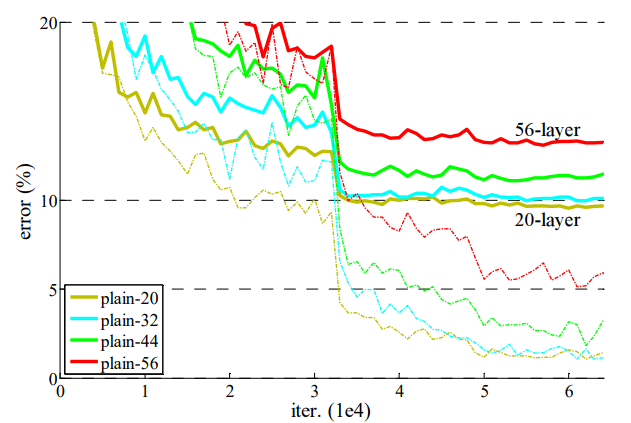


Imagem 1: Resultado do artigo sem utilizar conexões residuais

---

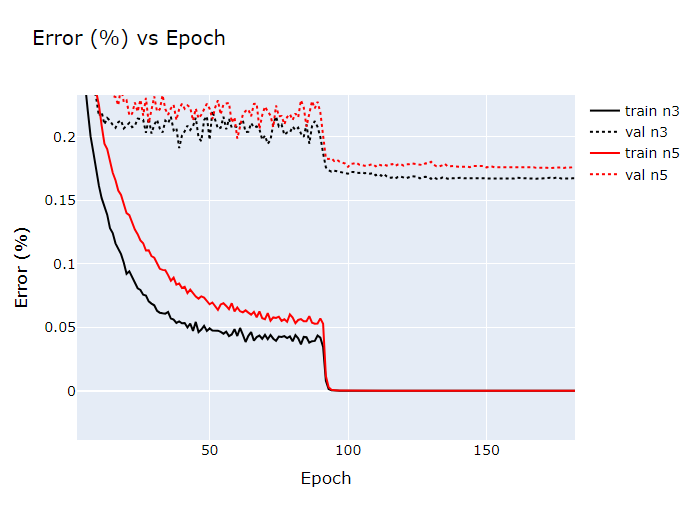


Imagem 2: Nosso resultado sem utilizar conexões residuais

---

Podemos observar extrema semelhança dos resultados do artigo com o do nosso experimento. A queda por volta da época 92 (32k steps) se dá devido ao decaimento do learning rate, e o modelo não obtem grandes mudanças depois da época 100. Os valores de erro não seguem iguais pois no artigo, apesar de não deixarem claro para esse experimento, podem ter seguido o top 5, diferente do nosso que segue o top 1. Entretanto, utilizando top 1 ainda foi possível replicar os resultados do artigo. <br><br>

Sem utilizar conexões resituais, o modelo com n=3 apresenta uma performance superior, como esperado e especificado ja no próprio artigo. Entretanto, ao utilizar as conexões residuais propostas, conforme as imagens 3 e 4, foi possivel obter um ganho de performance para redes mais profundas, ou seja, com as conexões o modelo com n=5 atingiu resultado superior ao modelo com n=3.

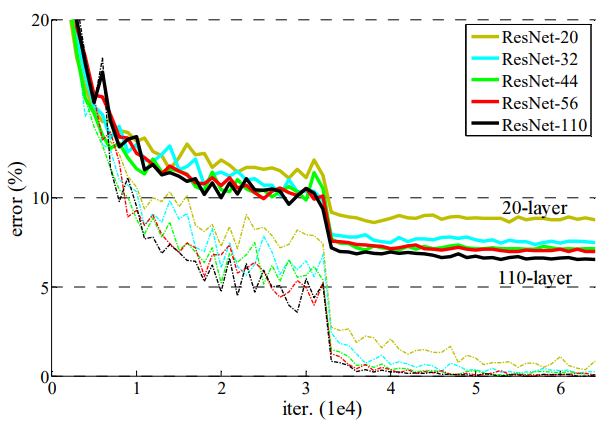


Imagem 3: Resultado do artigo utilizando conexões residuais

---

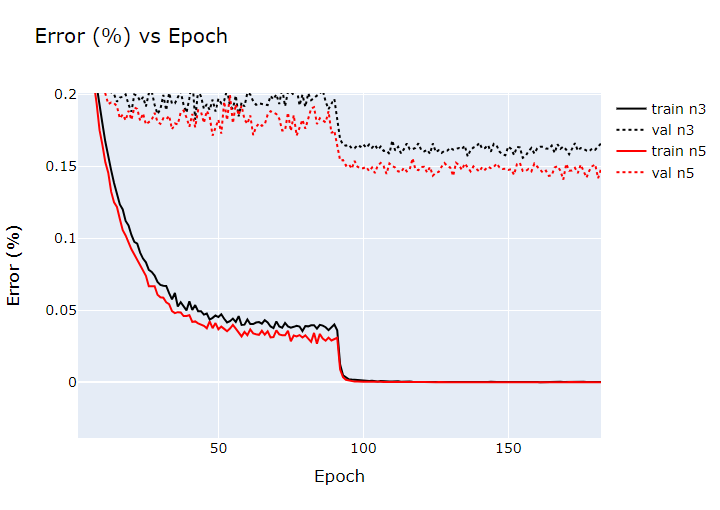


Imagem 4: Nosso resultado utilizando conexões residuais

---

Assim tivemos um ganho de performance significativo (especialmente comparando redes mais profundas com e sem conexões residuais, conforme as imagens 5 e 6).

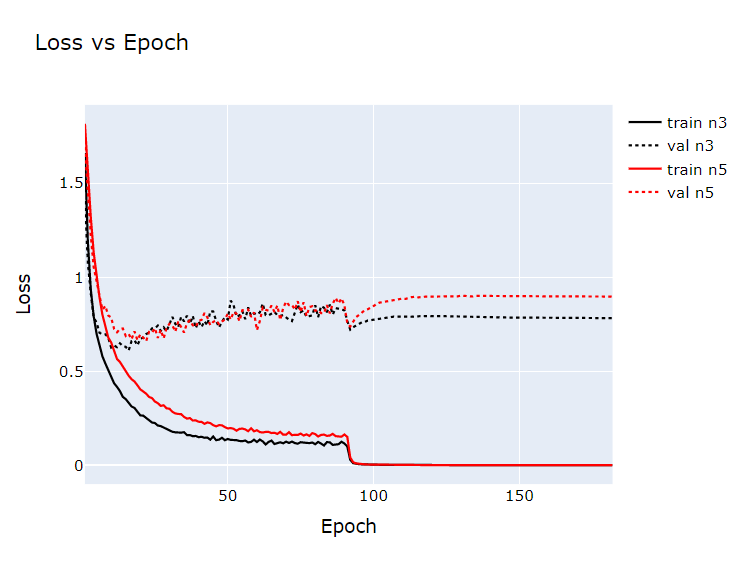

Imagem 5: Loss deste experimento sem utilizar conexões residuais

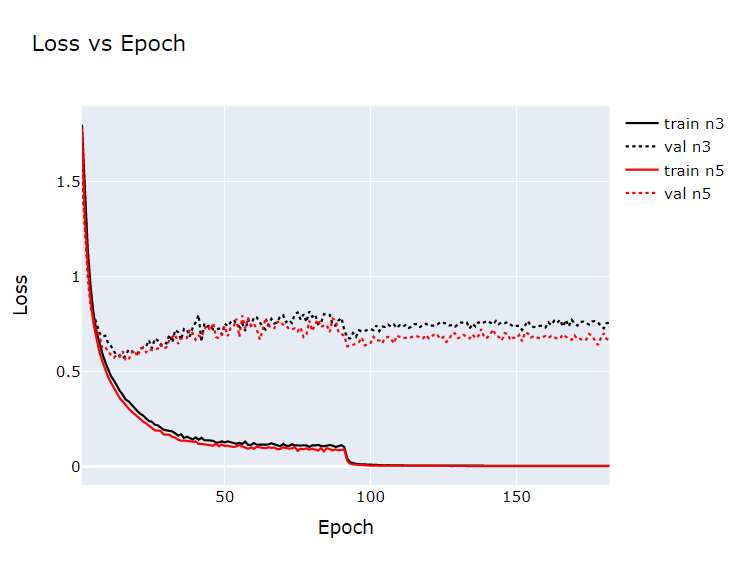

Imagem 6: Loss deste experimento utilizando conexões residuais

Dessa forma, o que se observou na métrica utilizada também é observado na loss: quando não utilizamos conexões residuais, o aumento do número de camadas (de 20 para 32) representou uma queda na performance, enquanto ao utilizar as conexões residuais houve uma melhora de performance.<br><br>

Em síntese, sem utilizar conexões residuais o modelo com n=3 se saiu melhor em ambos os experimentos, já com as conexões residuais o modelo com n=5 se saiu melhor.